### CLIP by OpenAI

Uses contrastive learning to learn image-text embeddings. The model is trained on a large dataset of images and captions from the web.

Here we are using the pre-trained model to check matching between images and captions.

In [1]:
import transformers
import numpy as np
import pandas as pd
import torch
from PIL import Image
import requests

from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

/Users/raghavendrakommavarapu/opt/anaconda3/envs/torch_2_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
device = torch.device("cpu")
print('Using device:', device)

model_id = "openai/clip-vit-base-patch32"

tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

Using device: cpu


In [13]:
urls=['https://cdn.pixabay.com/photo/2023/03/11/20/12/moon-7845194_1280.jpg',
    'https://cdn.pixabay.com/photo/2023/03/12/17/35/hare-7847442_1280.jpg',
    'https://images.unsplash.com/photo-1530281700549-e82e7bf110d6?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=688&q=80',
    'https://cdn.pixabay.com/photo/2022/10/11/12/25/fly-7514186_1280.jpg',
    'https://cdn.pixabay.com/photo/2023/01/08/05/31/indian-chat-7704561_1280.jpg'
    ]

images=[Image.open(requests.get(i, stream=True).raw)  for i in urls]

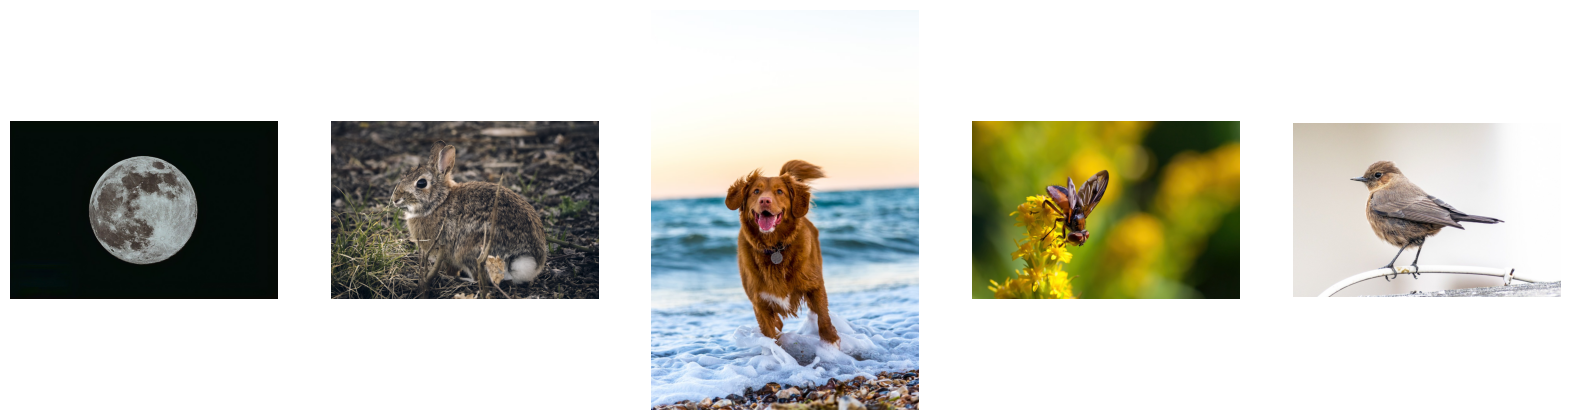

In [14]:
# plot all images
fig, axs = plt.subplots(1, len(images), figsize=(20, 20))
for i, ax in enumerate(axs):
    ax.imshow(images[i])
    ax.axis("off")
plt.show()

In [18]:
text_prompts=["a girl",'the moon', "a dog with a flower",'a bird', "a dog",'a rabbit running', "a dog at the beach", 'a bug', 'a rabbit sitting still']
inputs = inputs = processor(text=text_prompts, images=images, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image 
probs = logits_per_image.softmax(dim=1)

In [19]:
pd.DataFrame(probs.detach().numpy()*100, columns=text_prompts, 
index=list(['image1','image2', 'image3','image4', 'image5'])).style.background_gradient(axis=None,low=0, high=0.91).format(precision=2)

,a girl,the moon,a dog with a flower,a bird,a dog,a rabbit running,a dog at the beach,a bug,a rabbit sitting still
image1,0.00,99.97,0.00,0.01,0.01,0.01,0.00,0.00,0.00
image2,0.00,0.00,0.00,0.01,0.01,32.69,0.00,0.01,67.28
image3,0.01,0.00,0.08,0.01,0.97,0.56,98.37,0.00,0.00
image4,0.54,0.01,6.74,3.42,0.37,0.28,0.01,88.55,0.08
image5,0.04,0.00,0.00,99.88,0.01,0.00,0.00,0.06,0.01


> we can notice how effectively CLIP is able to pair images and captions, even when the captions are not very descriptive.

As a separate experiment, we can try to generate images from captions using Stable diffusion model.

## Stable diffusion pre-trained model

In [20]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
pipe = pipe.to("mps")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 68834.31it/s]
/Users/raghavendrakommavarapu/opt/anaconda3/envs/torch_2_env/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [21]:
pipe.enable_attention_slicing()

In [33]:
prompt = "a photo of an astronaut sipping coffee in space"

# warmup pass
_ = pipe(prompt, num_inference_steps=1)

100%|██████████| 1/1 [00:02<00:00,  2.55s/it]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


In [34]:
image = pipe(prompt).images[0]

100%|██████████| 50/50 [01:56<00:00,  2.32s/it]


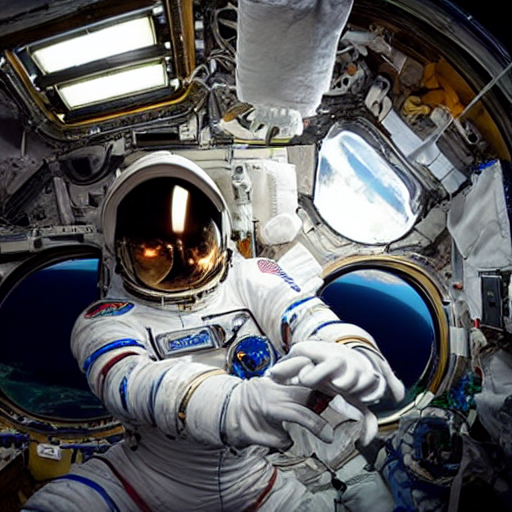

In [35]:
image

In [30]:
prompt = "a photo of a frog driving a truck"

# warmup pass
_ = pipe(prompt, num_inference_steps=1)

100%|██████████| 1/1 [00:02<00:00,  2.67s/it]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


In [31]:
image = pipe(prompt).images[0]

100%|██████████| 50/50 [01:57<00:00,  2.35s/it]


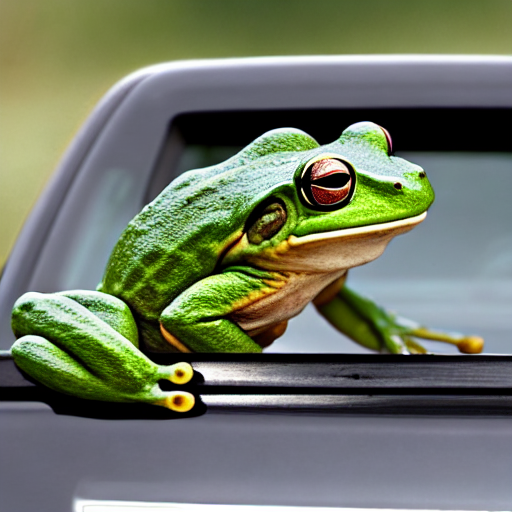

In [32]:
image

> We can see how the model is able to generate images quite close to the ones described by the captions.